In [35]:
from pymoo.operators.sampling.lhs import LHS
from pymoo.core.problem import Problem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.util.ref_dirs import get_reference_directions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C , WhiteKernel


In [9]:
class CustomProblem(Problem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2,xl=-10,xu=10)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            objective_1 = x[0]**3 + x[1]**2
            objective_2 = x[1]**2 + 4*x[0]
            objective_values = [objective_1,objective_2]
        else:
            for  i in range(len(x)):
                value = x[i]
                objective_1 = value[0]**3 + value[1]**2
                objective_2 = value[1]**2 + 4*value[0]
                objective_values.append([objective_1,objective_2])
        out["F"] = objective_values

In [11]:
sampling_function = LHS()
problem = CustomProblem()
samples = sampling_function(problem,20).get('X')

In [16]:
dataset = pd.DataFrame(data=samples,columns=['x1','x2'])
out = {}
objectives = []
problem._evaluate(samples,out)
objectives = out['F']
objective_1 = [i[0] for i in objectives]
objective_2 = [i[1] for i in objectives]
dataset['Objective_1'] = objective_1
dataset['Objective_2'] = objective_2
dataset.head()

,x1,x2,Objective_1,Objective_2
0,2.947755,-3.129029,35.404640,21.581843
1,-4.274019,8.326991,-8.735765,52.242705
2,-5.027075,-1.737284,-124.023465,-17.090144
3,-6.751610,9.964879,-208.468120,72.292377
4,8.437050,-6.985087,649.372822,82.539638


Text(0, 0.5, 'x2')

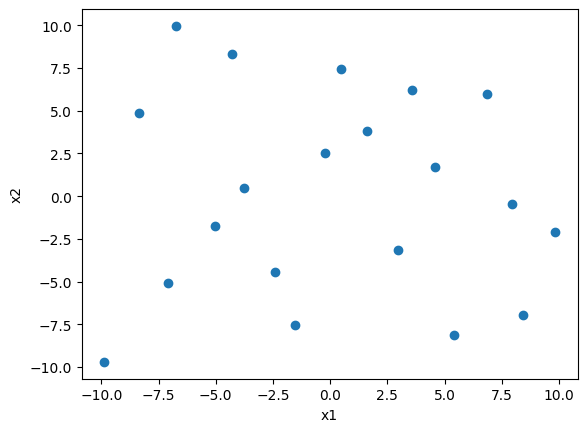

In [19]:
plt.scatter(dataset['x1'],dataset['x2'])
plt.xlabel('x1')
plt.ylabel('x2')

In [32]:
def evaluate_chebyshev(objective_vector,refference_vector):
    ideal_vector = [-1000,-40]
    chebyshev_eval = []
    for i in range(len(objective_vector)):
        chebyshev_eval.append(refference_vector[i]*(objective_vector[i]-ideal_vector[i]))
    return max(chebyshev_eval)

def scalarizing_function(objective_vector,refference_vector):
    z_ideal = [-1000,-40]
    z_nadir = [1000,40]

    objective_vector_normalized = [(objective_vector[0]-z_ideal[0])/(z_nadir[0]-z_ideal[0]),
                                   (objective_vector[1]-z_ideal[1])/(z_nadir[1]-z_ideal[1])]
    
        #print('Objective Vector is {0} and scalar value is {1} '.format(objective_vector_normalized,
                                                                    #evaluate_chebyshev(objective_vector_normalized,[0.5, 0.5])))
    return evaluate_chebyshev(objective_vector_normalized,refference_vector)

In [25]:
objective_values = dataset[['Objective_1','Objective_2']].to_numpy()

In [29]:
weight_vectors = get_reference_directions('energy',2,100)

In [33]:
scalarized_values = []
for i in range(len(objective_values)):
    scalarized_values.append(scalarizing_function(objective_values[i],weight_vectors[0]))

dataset['G'] = scalarized_values

In [34]:
dataset.head()

,x1,x2,Objective_1,Objective_2,G
0,2.947755,-3.129029,35.404640,21.581843,40.769773
1,-4.274019,8.326991,-8.735765,52.242705,41.153034
2,-5.027075,-1.737284,-124.023465,-17.090144,40.286373
3,-6.751610,9.964879,-208.468120,72.292377,41.403655
4,8.437050,-6.985087,649.372822,82.539638,41.531745


In [36]:
columns = ['x1','x2']

In [37]:
X = dataset[columns].to_numpy()
Y = dataset['G'].to_numpy().reshape(-1,1)

In [38]:
kernel_2 = C(4.0) * RBF(length_scale=0.1) + WhiteKernel()
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=90,normalize_y=True,random_state=11).fit(X,Y)


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fi